# **Classifying Student Academic Performance Using Machine Learning**

**Goal:**  
Build and evaluate machine learning models to classify student performance (Low / Medium / High) using academic, behavioural, and socio-economic features.

**Key Steps**
1. Import dataset from the **UCI Machine Learning Repository**  
2. Perform **EDA and preprocessing**  
3. Engineer **Low/Medium/High** target categories from grades  
4. Train **Logistic Regression**, **KNN**, and **SVC** models  
5. Evaluate performance with metrics and visualizations  
6. Interpret model importance using **Permutation Importance**


# **Import Libraries**
This cell installs and imports all necessary libraries for data loading, preprocessing, visualization, and model building.


In [45]:
pip install ucimlrepo

In [46]:

import warnings
warnings.filterwarnings('ignore')
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
from sklearn.inspection import permutation_importance

from time import perf_counter
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(" Libraries imported successfully.")


 Libraries imported successfully.


# **Load Dataset from UCI Repository**
We fetch the **Student Performance** dataset (ID = 320) directly using the `ucimlrepo` library.


In [47]:
# Fetch dataset
student_performance = fetch_ucirepo(id=320)

# Extract features and target
X = student_performance.data.features
y = student_performance.data.targets

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Combine into a single DataFrame
df = pd.concat([X, y], axis=1)
print("Combined DataFrame shape:", df.shape)

df.head()


Features shape: (649, 30)
Target shape: (649, 3)
Combined DataFrame shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


# **Exploratory Data Analysis (EDA)**
Let's explore data types, missing values, and summary statistics to understand dataset structure.


=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    o

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


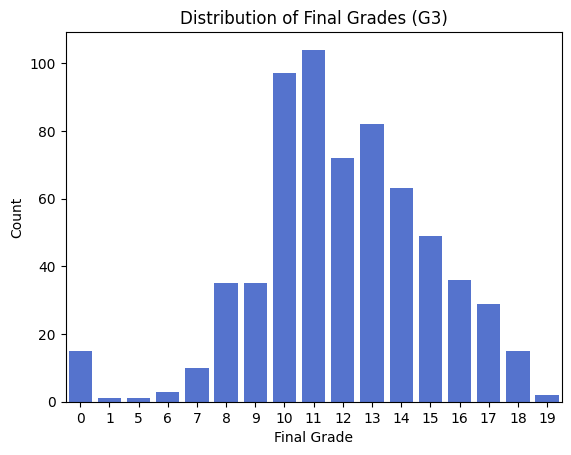

In [48]:
# Display dataset info
print("=== Dataset Info ===")
print(df.info())

# Missing values
print("\n=== Missing Values ===")
print(df.isna().sum().sort_values(ascending=False).head(10))

# Summary statistics
display(df.describe())

# Countplot for target variable
sns.countplot(x='G3', data=df, color='royalblue')
plt.title("Distribution of Final Grades (G3)")
plt.xlabel("Final Grade")
plt.ylabel("Count")
plt.show()


# **Target Engineering — Create Performance Labels**
We convert numeric grades (**G3**) into three performance levels:
- **Low:** 0–9  
- **Medium:** 10–14  
- **High:** 15–20


performance
Medium    418
High      131
Low       100
Name: count, dtype: int64


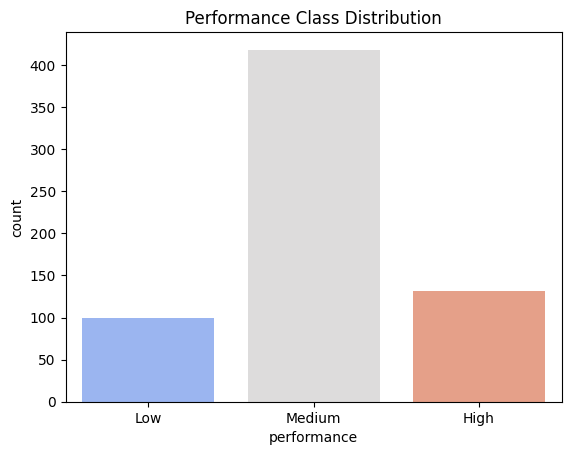

In [49]:
bins = [-1, 9, 14, 20]
labels = ["Low", "Medium", "High"]
df["performance"] = pd.cut(df["G3"], bins=bins, labels=labels)

# Drop rows with missing target if any
df = df.dropna(subset=["performance"])
print(df["performance"].value_counts())

sns.countplot(x='performance', data=df, palette='coolwarm')
plt.title("Performance Class Distribution")
plt.show()


### **Further Data Exploration**

Let's visualize the data to understand feature distributions and relationships.

In [50]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()



print("Numeric columns for plotting:", numeric_cols[:10])
print("Categorical columns for plotting:", categorical_cols[:10])

Numeric columns for plotting: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc']
Categorical columns for plotting: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup']


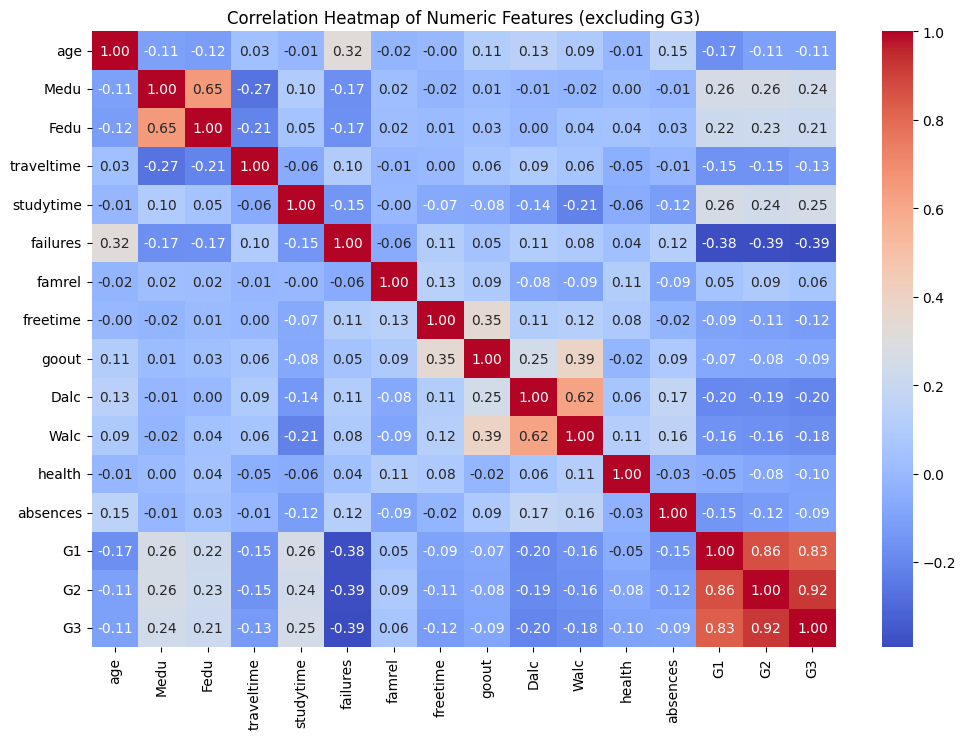

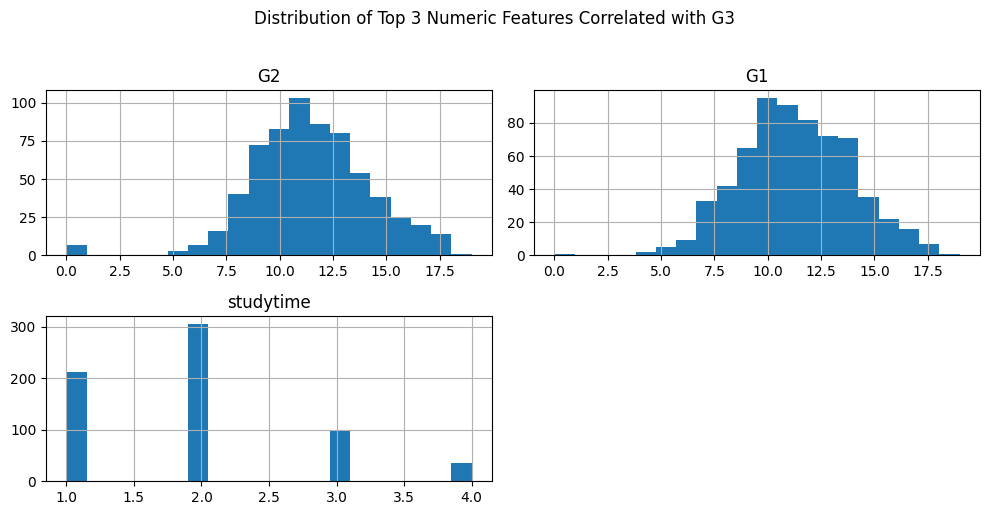

In [51]:
# Correlation heatmap (between numeric features, excluding G3 as per prior processing)
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features (excluding G3)")
plt.show()

# Select top 3 numerical columns most correlated with G3
# For this calculation, we need G3 to be present in the DataFrame
# We will use the full DataFrame for correlation and then extract G3's correlations.
correlations = df.select_dtypes(include=np.number).corr()['G3'].sort_values(ascending=False)

# Exclude G3 itself and then select top 3
top_correlated_cols = correlations.index[1:4].tolist()

# Distribution plots for top correlated numerical features
df[top_correlated_cols].hist(figsize=(10, 5), bins=20)
plt.suptitle("Distribution of Top 3 Numeric Features Correlated with G3", y=1.02)
plt.tight_layout()
plt.show()

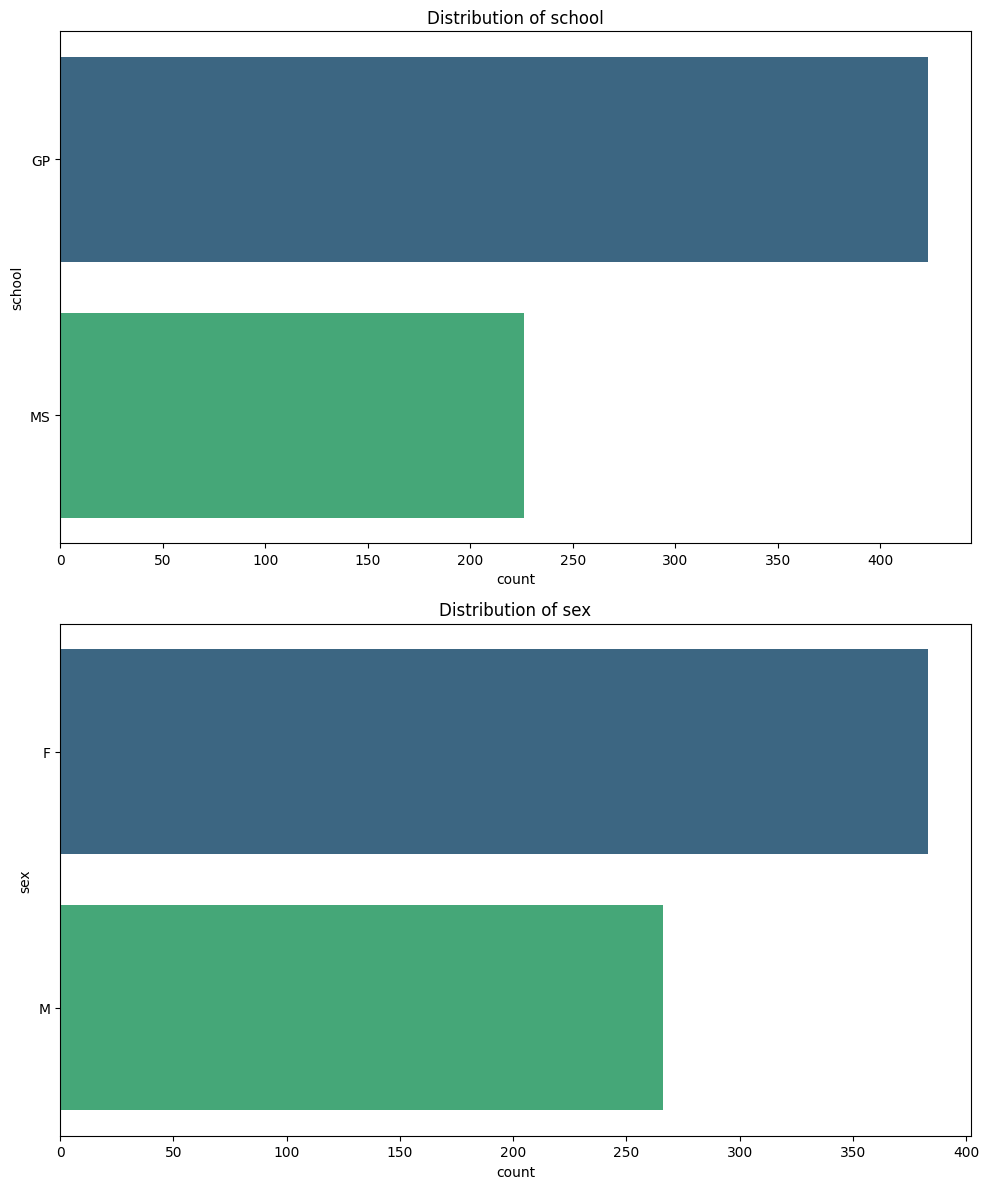

In [52]:
# Distribution plots for categorical features
# You can specify which columns to plot by changing the list below.
cols_to_plot = categorical_cols[:2] # Example: plots the first two categorical columns

fig, axes = plt.subplots(nrows=len(cols_to_plot), ncols=1, figsize=(10, 6 * len(cols_to_plot)))

# Ensure axes is an array even if only one column is plotted
if len(cols_to_plot) == 1:
    axes = [axes]

for i, col in enumerate(cols_to_plot):
    sns.countplot(y=col, data=df, ax=axes[i], palette='viridis')
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

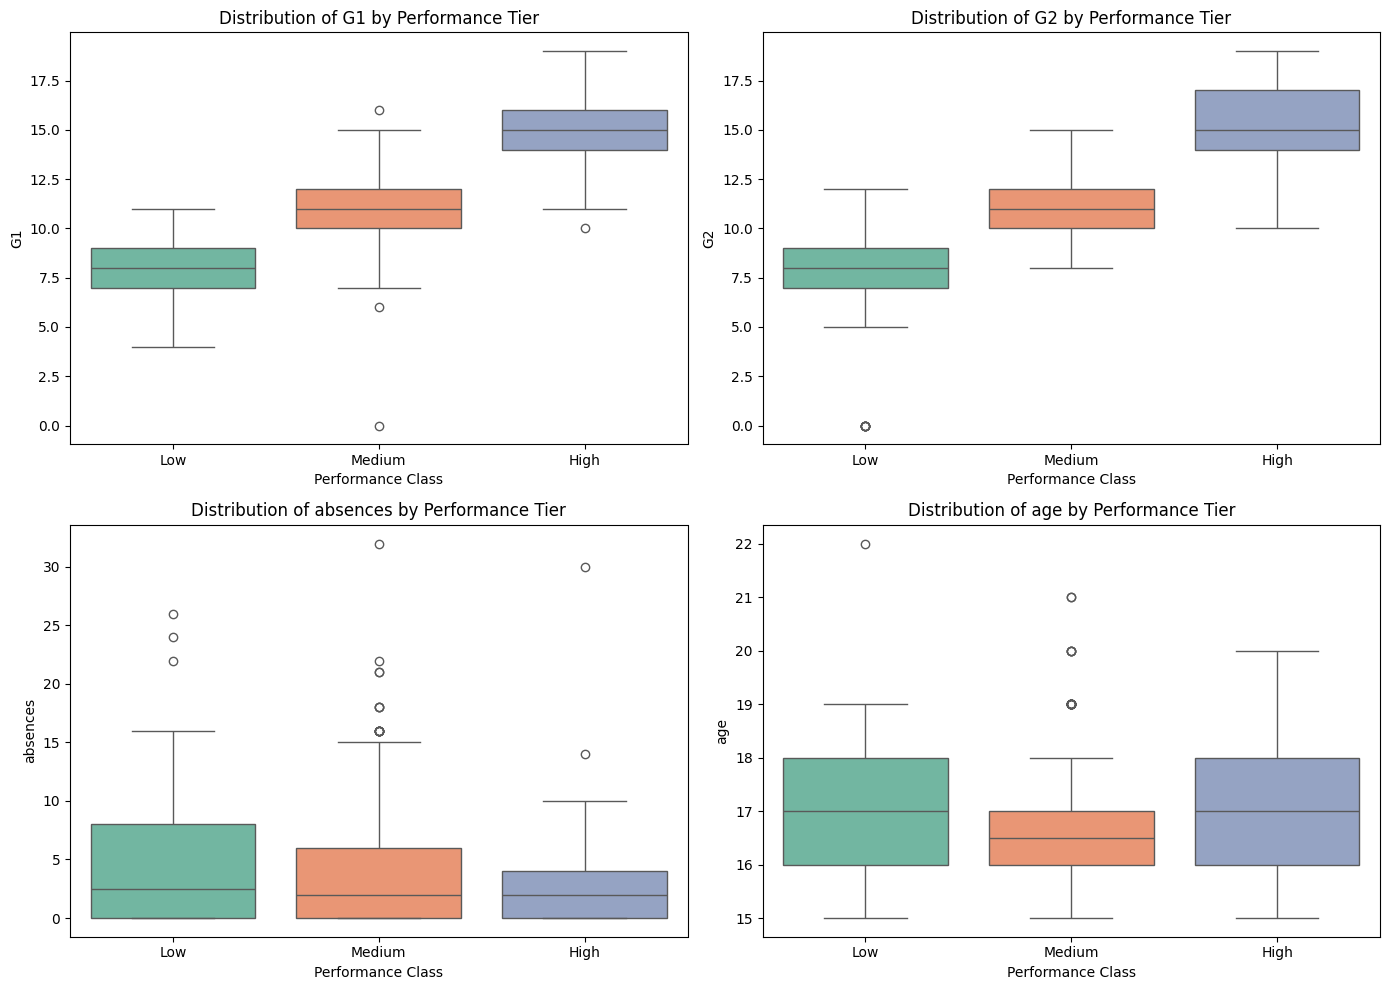

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---  Ensure Target 'performance' exists for visualization ---
# Re-creating the bins just in case (Low: 0-9, Medium: 10-14, High: 15-20).
if 'performance' not in df.columns:
    bins = [-1, 9, 14, 20]
    labels = ['Low', 'Medium', 'High']
    df['performance'] = pd.cut(df['G3'], bins=bins, labels=labels)

# ---Box Plots of Key Numeric Features by Performance Class ---
# This shows the distribution of G1, G2, and Absences for each class.
numeric_features_to_check = ['G1', 'G2', 'absences', 'age']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_features_to_check):
    sns.boxplot(x='performance', y=col, data=df, ax=axes[i], palette='Set2', order=['Low', 'Medium', 'High'])
    axes[i].set_title(f'Distribution of {col} by Performance Tier')
    axes[i].set_ylabel(col)
    axes[i].set_xlabel('Performance Class')

plt.tight_layout()
plt.show()

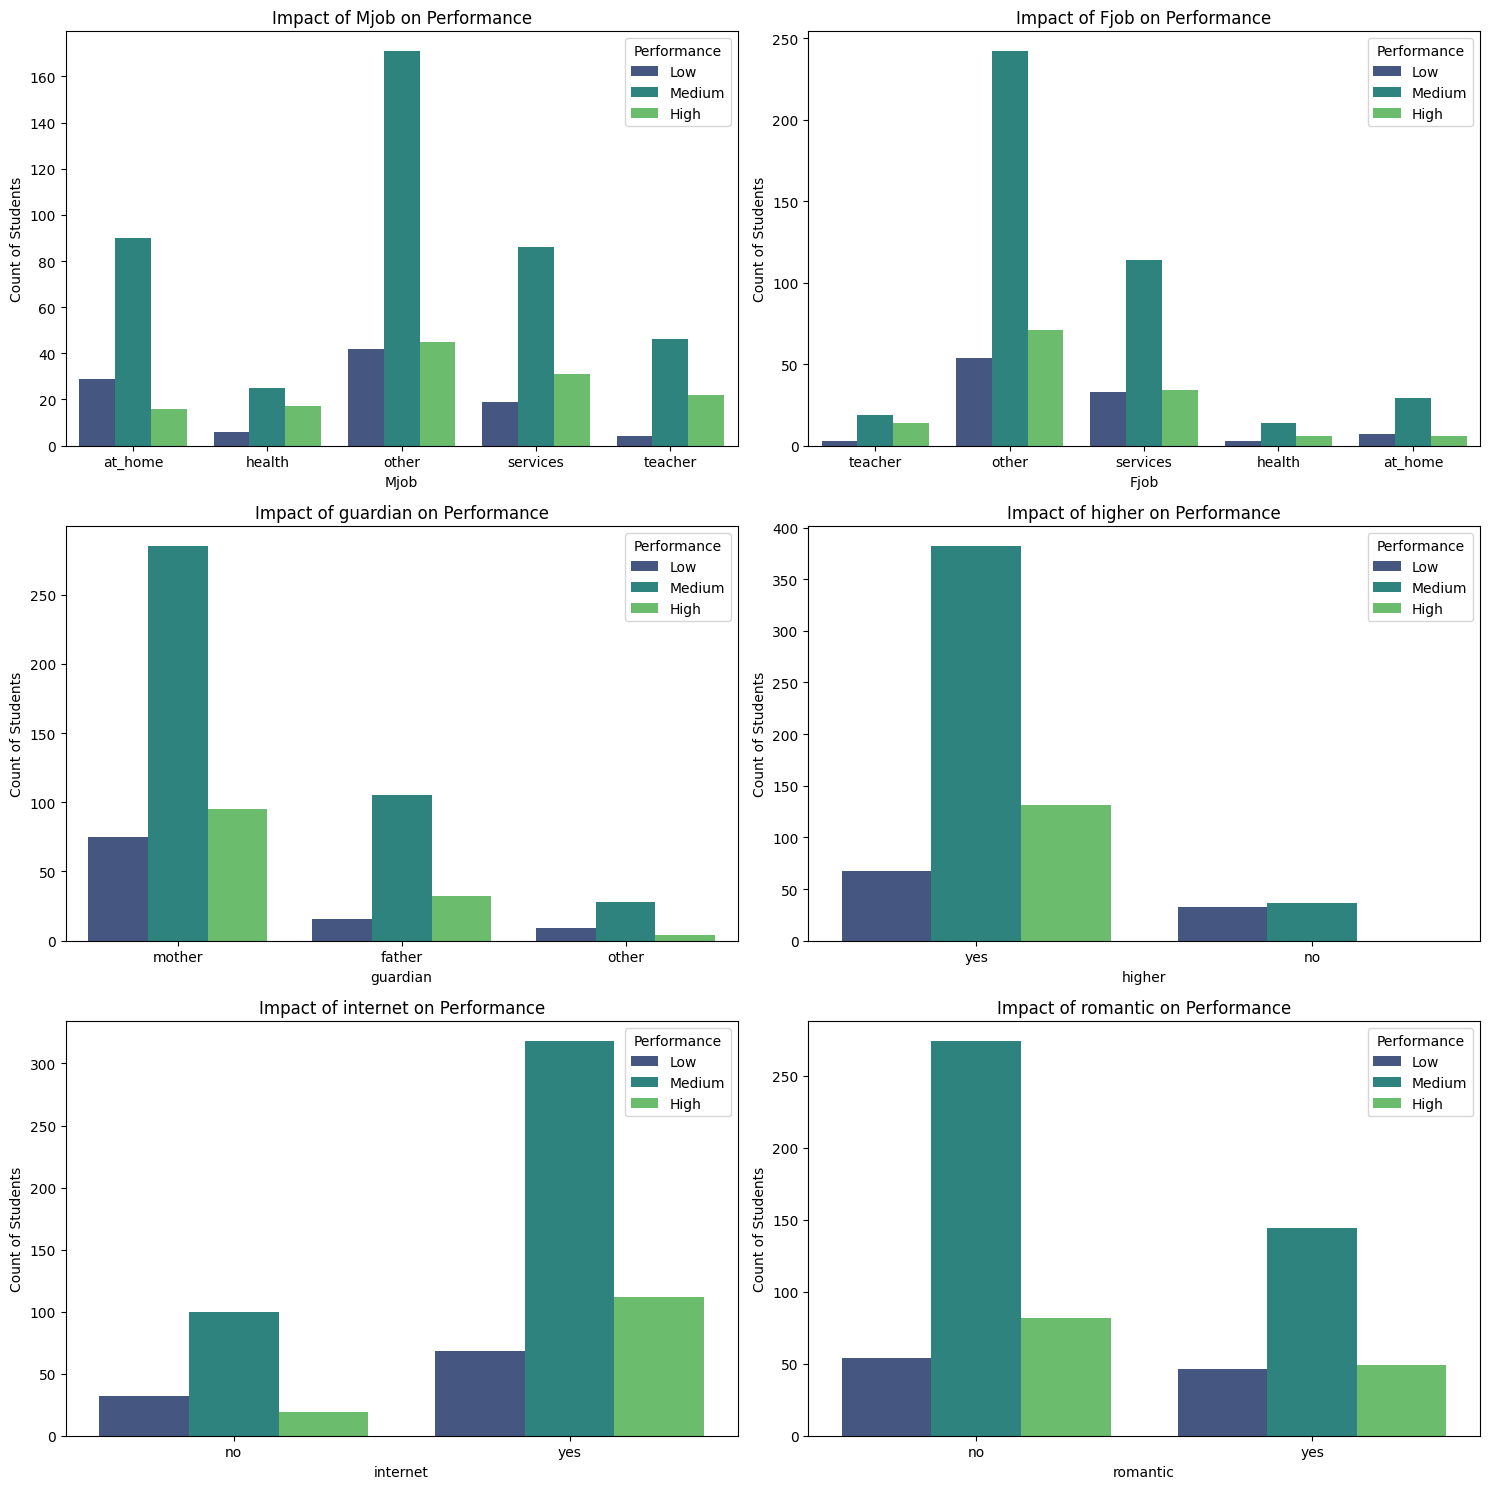

In [54]:
# ---  Count Plots with Hue for Socio-Economic Factors ---
# We use 'hue' to separate the performance classes within each category.
socio_economic_cols = ['Mjob', 'Fjob', 'guardian', 'higher', 'internet', 'romantic']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(socio_economic_cols):
    # Using countplot with hue='performance' shows the breakdown of classes per category
    sns.countplot(x=col, hue='performance', data=df, ax=axes[i], palette='viridis', hue_order=['Low', 'Medium', 'High'])
    axes[i].set_title(f'Impact of {col} on Performance')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count of Students')
    axes[i].legend(title='Performance', loc='upper right')

plt.tight_layout()
plt.show()

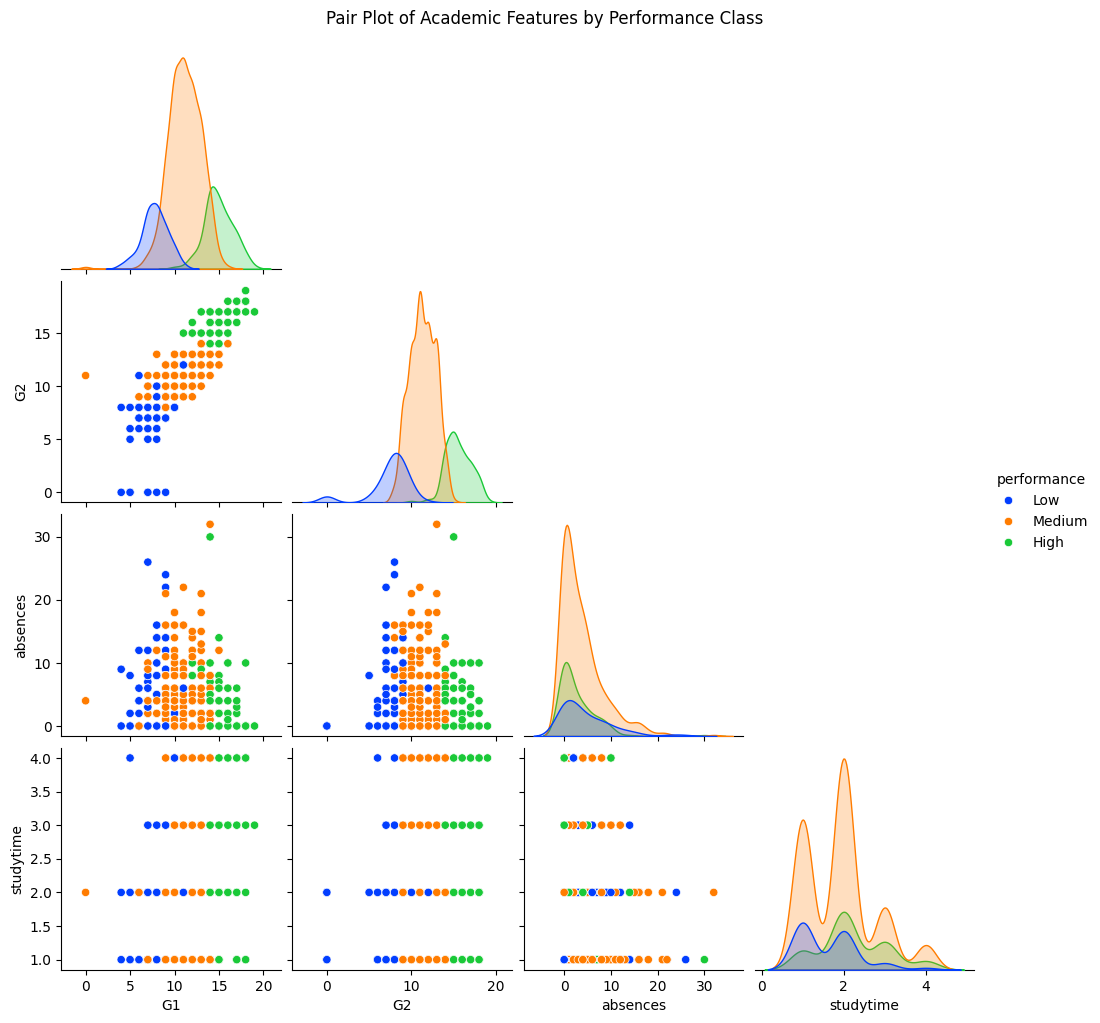

In [55]:
# --- Pair Plot of Academic Features Colored by Target ---
# This visualizes if the classes are linearly separable (helpful for justifying Logistic Regression).
# We include G1, G2, absences, and studytime.
cols_for_pairplot = ['G1', 'G2', 'absences', 'studytime', 'performance']

sns.pairplot(df[cols_for_pairplot], hue='performance', hue_order=['Low', 'Medium', 'High'], palette='bright', corner=True)
plt.suptitle("Pair Plot of Academic Features by Performance Class", y=1.02)
plt.show()

# **Feature Selection and Preprocessing**
We separate features and target, identify categorical and numerical columns, and create a preprocessing pipeline with:
- **Imputation** for missing values  
- **Standard Scaling** for numerics  
- **One-Hot Encoding** for categoricals


In [56]:
target = "performance"
X = df.drop(columns=["performance","G3"])
y = df[target]

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print("Numeric columns:", numeric_cols[:10])
print("Categorical columns:", categorical_cols[:10])

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

print(" Preprocessing pipeline ready.")


Numeric columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc']
Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup']
 Preprocessing pipeline ready.


In [57]:
X

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,1,1,3,4,0,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,no,5,3,3,1,1,3,2,9,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,no,4,3,2,2,3,3,6,12,13
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,3,2,2,1,1,5,0,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,4,3,2,1,2,5,0,11,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,no,5,4,2,1,2,5,4,10,11
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,no,4,3,4,1,1,1,4,15,15
646,MS,F,18,U,GT3,T,1,1,other,other,...,no,1,1,1,1,1,5,6,11,12
647,MS,M,17,U,LE3,T,3,1,services,services,...,no,2,4,5,3,4,2,6,10,10


# **Model Training**

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "| Test size:", X_test.shape)

# Fit on train; transform train & test
preprocessor_fitted = preprocessor.fit(X_train)

X_train_proc = preprocessor_fitted.transform(X_train)
X_test_proc  = preprocessor_fitted.transform(X_test)

# Keep the class list for ROC binarization (sorted for stability)
classes = sorted(y.unique())
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin  = label_binarize(y_test, classes=classes)

n_classes = len(classes)
print("Processed shapes:", X_train_proc.shape, X_test_proc.shape, "| classes:", classes)


Train size: (519, 32) | Test size: (130, 32)
Processed shapes: (519, 58) (130, 58) | classes: ['High', 'Low', 'Medium']


# **Defining models for training**

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        multi_class="auto"
        # optionally: class_weight="balanced"
    ),
    "KNN_k7": KNeighborsClassifier(
        n_neighbors=7
        # optionally: weights="distance", p=1 (Manhattan) or 2 (Euclidean)
    ),
    "SVC_rbf": SVC(
        kernel="rbf",
        probability=True,  # needed for predict_proba and ROC
        random_state=42
        # optionally: C=1.0, gamma="scale"
    )
}



===== LogisticRegression =====
Train time: 0.0409s | Predict time: 0.0004s
Accuracy: 0.8308 | F1-macro: 0.7879 | ROC-AUC (macro OVR): 0.9479

Classification Report:
              precision    recall  f1-score   support

        High     0.8636    0.7308    0.7917        26
         Low     0.7000    0.7000    0.7000        20
      Medium     0.8523    0.8929    0.8721        84

    accuracy                         0.8308       130
   macro avg     0.8053    0.7745    0.7879       130
weighted avg     0.8311    0.8308    0.8295       130



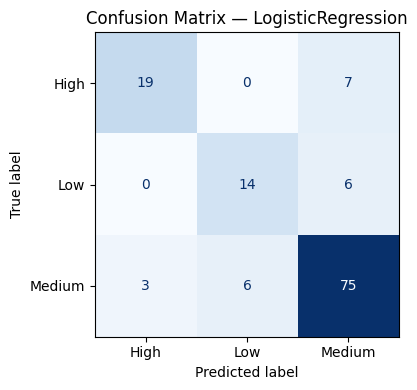


===== KNN_k7 =====
Train time: 0.0014s | Predict time: 0.0018s
Accuracy: 0.7538 | F1-macro: 0.6301 | ROC-AUC (macro OVR): 0.8848

Classification Report:
              precision    recall  f1-score   support

        High     0.7391    0.6538    0.6939        26
         Low     0.7143    0.2500    0.3704        20
      Medium     0.7600    0.9048    0.8261        84

    accuracy                         0.7538       130
   macro avg     0.7378    0.6029    0.6301       130
weighted avg     0.7488    0.7538    0.7295       130



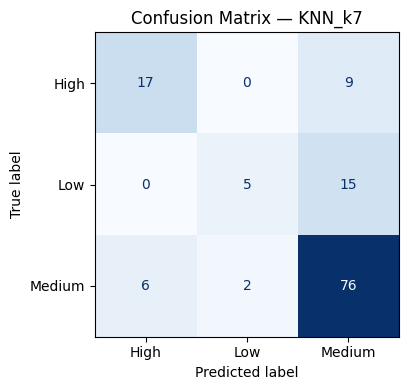


===== SVC_rbf =====
Train time: 0.0768s | Predict time: 0.0051s
Accuracy: 0.8615 | F1-macro: 0.8064 | ROC-AUC (macro OVR): 0.9474

Classification Report:
              precision    recall  f1-score   support

        High     0.9048    0.7308    0.8085        26
         Low     1.0000    0.5500    0.7097        20
      Medium     0.8367    0.9762    0.9011        84

    accuracy                         0.8615       130
   macro avg     0.9138    0.7523    0.8064       130
weighted avg     0.8755    0.8615    0.8531       130



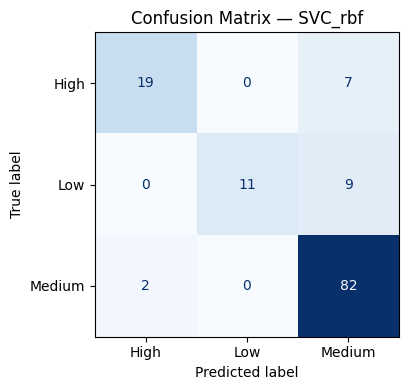

In [60]:
results = {}

for name, model in models.items():
    # --- Train time
    t0 = perf_counter()
    model.fit(X_train_proc, y_train)
    train_time = perf_counter() - t0

    # --- Predict & proba time
    t1 = perf_counter()
    y_pred = model.predict(X_test_proc)
    pred_time = perf_counter() - t1

    # --- Metrics
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    # Some models expose predict_proba; (all chosen do).
    y_score = model.predict_proba(X_test_proc)

    # ROC-AUC (one-vs-rest, macro)
    roc_auc_macro = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")

    # Store
    results[name] = {
        "model": model,
        "train_time_s": train_time,
        "pred_time_s": pred_time,
        "accuracy": acc,
        "f1_macro": f1m,
        "roc_auc_macro": roc_auc_macro,
        "y_pred": y_pred,
        "y_score": y_score
    }

    # --- Print report
    print(f"\n===== {name} =====")
    print(f"Train time: {train_time:.4f}s | Predict time: {pred_time:.4f}s")
    print(f"Accuracy: {acc:.4f} | F1-macro: {f1m:.4f} | ROC-AUC (macro OVR): {roc_auc_macro:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    # --- Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()


# **ROC Curve for Models**

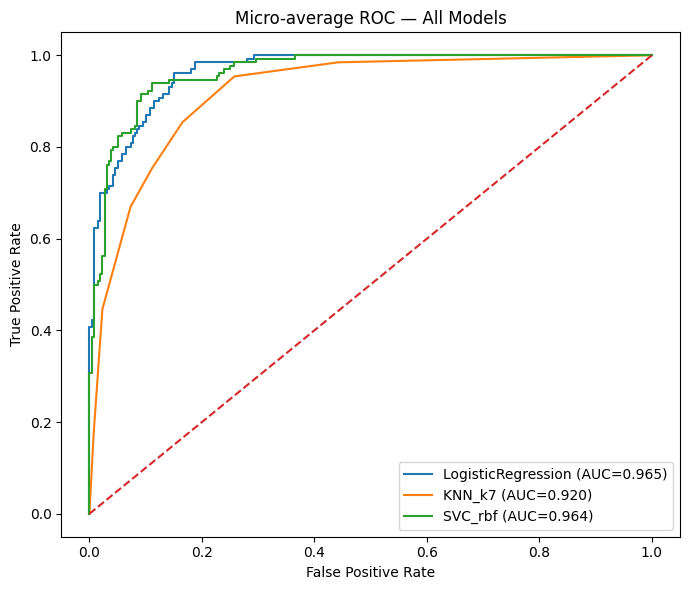

In [61]:
plt.figure(figsize=(7,6))

for name, res in results.items():
    # Micro-average ROC: treat every class-vs-rest instance as a binary decision and aggregate
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), res["y_score"].ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-average ROC — All Models")
plt.legend()
plt.tight_layout()
plt.show()


# **Summarized Result of all models**

In [62]:
summary = pd.DataFrame([
    {
        "model": name,
        "accuracy": res["accuracy"],
        "f1_macro": res["f1_macro"],
        "roc_auc_macro": res["roc_auc_macro"],
        "train_time_s": res["train_time_s"],
        "pred_time_s": res["pred_time_s"],
    }
    for name, res in results.items()
]).sort_values(by=["roc_auc_macro","f1_macro","accuracy"], ascending=False, ignore_index=True)

summary


,model,accuracy,f1_macro,roc_auc_macro,train_time_s,pred_time_s
0,LogisticRegression,0.830769,0.787920,0.947925,0.040857,0.000411
1,SVC_rbf,0.861538,0.806429,0.947437,0.076782,0.005088
2,KNN_k7,0.753846,0.630112,0.884806,0.001359,0.001751


# **Model's Parameter tuning with Baysian Optimization Technique**


>>> OPTIMIZING MODEL: LogisticRegression

[Best Parameters]: {'C': np.float64(1.0129197956845732), 'max_iter': 763, 'penalty': 'l2', 'solver': 'lbfgs'}

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

        High       0.86      0.73      0.79        26
         Low       0.70      0.70      0.70        20
      Medium       0.85      0.89      0.87        84

    accuracy                           0.83       130
   macro avg       0.81      0.77      0.79       130
weighted avg       0.83      0.83      0.83       130



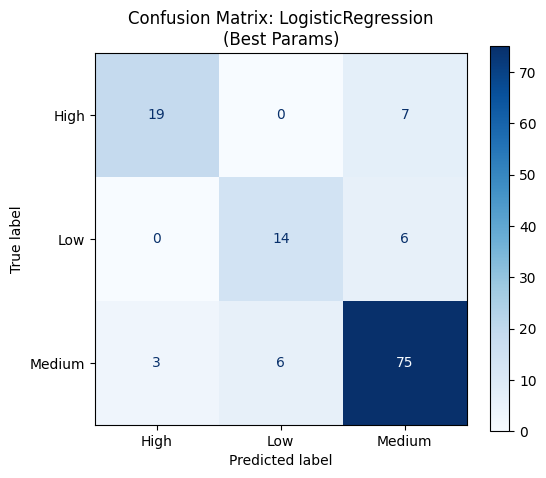


>>> OPTIMIZING MODEL: KNN_k7

[Best Parameters]: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

Classification Report for KNN_k7:
              precision    recall  f1-score   support

        High       0.65      0.65      0.65        26
         Low       0.53      0.45      0.49        20
      Medium       0.77      0.80      0.78        84

    accuracy                           0.72       130
   macro avg       0.65      0.63      0.64       130
weighted avg       0.71      0.72      0.71       130



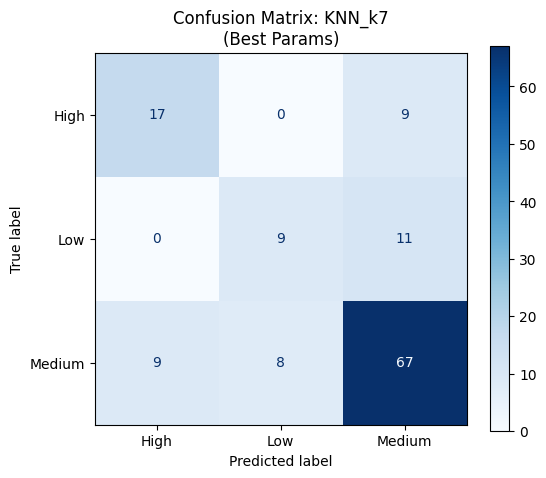


>>> OPTIMIZING MODEL: SVC_rbf

[Best Parameters]: {'C': np.float64(31.428808908401084), 'gamma': np.float64(0.0007068974950624604), 'kernel': 'rbf'}

Classification Report for SVC_rbf:
              precision    recall  f1-score   support

        High       0.90      0.69      0.78        26
         Low       0.88      0.70      0.78        20
      Medium       0.85      0.95      0.90        84

    accuracy                           0.86       130
   macro avg       0.88      0.78      0.82       130
weighted avg       0.86      0.86      0.86       130



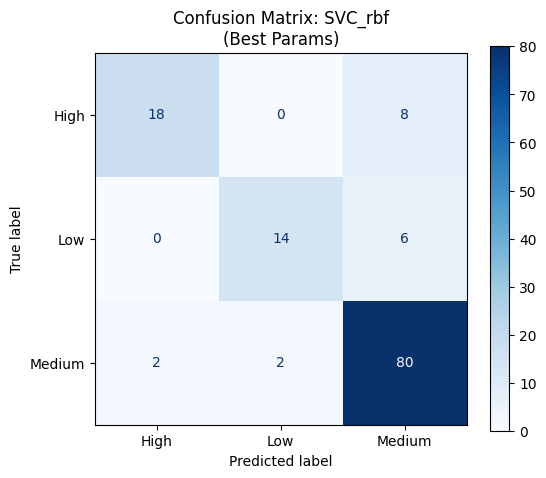


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 FINAL PERFORMANCE SUMMARY 
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                                                                                                           Best_Params  Accuracy  F1_Macro  ROC_AUC  Search_Time_s
SVC_rbf             {'C': np.float64(31.428808908401084), 'gamma': np.float64(0.0007068974950624604), 'kernel': 'rbf'}    0.8615    0.8198   0.9533           0.88
LogisticRegression          {'C': np.float64(1.0129197956845732), 'max_iter': 763, 'penalty': 'l2', 'solver': 'lbfgs'}    0.8308    0.7879   0.9480           0.20
KNN_k7                                                               {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}    0.7154    0.6413   0.8086           0.09


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.stats import loguniform, randint

# Metrics & Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

results = {}

# Define parameter grids for RandomizedSearchCV
param_grids = {
    "LogisticRegression": {
        "C": loguniform(0.001, 100),
        "solver": ["lbfgs", "liblinear"],
        "penalty": ["l2"], # lbfgs only supports l2, liblinear supports l1/l2
        "max_iter": randint(100, 1000)
    },
    "KNN_k7": {
        "n_neighbors": randint(1, 20),
        "weights": ["uniform", "distance"],
        "p": [1, 2]
    },
    "SVC_rbf": {
        "C": loguniform(0.1, 100),
        "gamma": loguniform(0.0001, 1),
        "kernel": ["rbf"]
    }
}

# 1. Loop through the models and apply Randomized Search
for name, model in models.items():
    print(f"\n" + "="*60)
    print(f">>> OPTIMIZING MODEL: {name}")
    print("="*60)

    # Initialize RandomizedSearchCV
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[name],
        n_iter=10,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=42
    )

    # --- Search and Refit time
    t0 = perf_counter()
    search.fit(X_train_proc, y_train)
    train_time = perf_counter() - t0

    # Get the best estimator and predict
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_proc)

    # --- 1. Print Text Report & Best Params
    print(f"\n[Best Parameters]: {search.best_params_}")
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=classes))

    # --- 2. Plot Confusion Matrix
    # Using the best_model to visualize performance
    fig, ax = plt.subplots(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(f"Confusion Matrix: {name}\n(Best Params)")
    plt.show()

    # --- 3. Metric Calculations for final table
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    y_score = best_model.predict_proba(X_test_proc)
    roc_auc_macro = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")

    # Store all details including Best_Params
    results[name] = {
        "Best_Params": str(search.best_params_),
        "Accuracy": round(acc, 4),
        "F1_Macro": round(f1m, 4),
        "ROC_AUC": round(roc_auc_macro, 4),
        "Search_Time_s": round(train_time, 2)
    }

# 2. Print Final Comparative Table
print("\n" + "!"*30)
print(" FINAL PERFORMANCE SUMMARY ")
print("!"*30)

summary_df = pd.DataFrame.from_dict(results, orient='index')
print(summary_df.sort_values(by="F1_Macro", ascending=False).to_string())

# **Startified K-Fold Cross Validation**

In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# 1. Prepare Target (Encode strings to integers for safety with KNN)
le = LabelEncoder()
y_encoded = pd.Series(le.fit_transform(y))  # Ensure y is a Series with integer labels
classes = sorted(y_encoded.unique())        # [0, 1, 2]
# 2. Define Models with the NEW Optimized Hyperparameters
models = {
    "LogReg_Tuned": LogisticRegression(
        C=0.39079671568228835,      # Exact C from your result
        solver='lbfgs',             # Exact solver from your result
        max_iter=2000,
        random_state=42
    ),
    "KNN_Tuned": KNeighborsClassifier(
        n_neighbors=6,               # Exact neighbor count from your result
        p=2,                         # Exact p (Euclidean) from your result
        weights='distance'           # Exact weights from your result
    ),
    "SVC_Tuned": SVC(
        C=34.70266988650411,         # Exact C from your result
        gamma='auto',                # Exact Gamma from your result
        kernel='rbf',
        probability=True,            # Required for ROC-AUC
        random_state=42
    )
}

# 3. Stratified K-Fold Loop
# (Using the same skf logic to ensure robust validation)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Starting 5-Fold CV on {len(models)} tuned models...\n")

for name, base_model in models.items():
    accs, f1s, aucs = [], [], []

    for tr, va in skf.split(X, y_encoded):
        # Slice X and y
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y_encoded.iloc[tr], y_encoded.iloc[va]

        # Fit/Transform Preprocessor inside fold to prevent data leakage
        prep = clone(preprocessor).fit(X_tr)
        X_tr_p = prep.transform(X_tr)
        X_va_p = prep.transform(X_va)

        # Train Model
        model = clone(base_model).fit(X_tr_p, y_tr)

        # Predict
        y_pred = model.predict(X_va_p)
        y_score = model.predict_proba(X_va_p)

        # Metrics
        accs.append(accuracy_score(y_va, y_pred))
        f1s.append(f1_score(y_va, y_pred, average="macro"))

        # Binarize labels for ROC-AUC
        y_va_bin = label_binarize(y_va, classes=classes)
        if y_va_bin.shape[1] == len(classes):
            aucs.append(roc_auc_score(y_va_bin, y_score, average="macro", multi_class="ovr"))

    print(f"===== {name} =====")
    print(f"Acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"F1 : {np.mean(f1s):.4f}  ± {np.std(f1s):.4f}")
    if aucs:
        print(f"AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}\n")
    else:
        print("AUC: N/A\n")

Starting 5-Fold CV on 3 tuned models...

===== LogReg_Tuned =====
Acc: 0.8551 ± 0.0158
F1 : 0.8168  ± 0.0221
AUC: 0.9531 ± 0.0110

===== KNN_Tuned =====
Acc: 0.7580 ± 0.0401
F1 : 0.6456  ± 0.0485
AUC: 0.8681 ± 0.0239

===== SVC_Tuned =====
Acc: 0.8289 ± 0.0320
F1 : 0.7886  ± 0.0399
AUC: 0.9437 ± 0.0156



# **Analysis of Influential Predictors**

To understand which factors contribute most to student performance, we analyze the **magnitude** of the Logistic Regression coefficients.

Since the data has been scaled (normalized), the absolute value of a feature's coefficient represents its weight in the model's decision-making process. Larger absolute values indicate features that have a stronger predictive power, regardless of whether that impact is positive or negative.

Analyzing coefficients for class: High


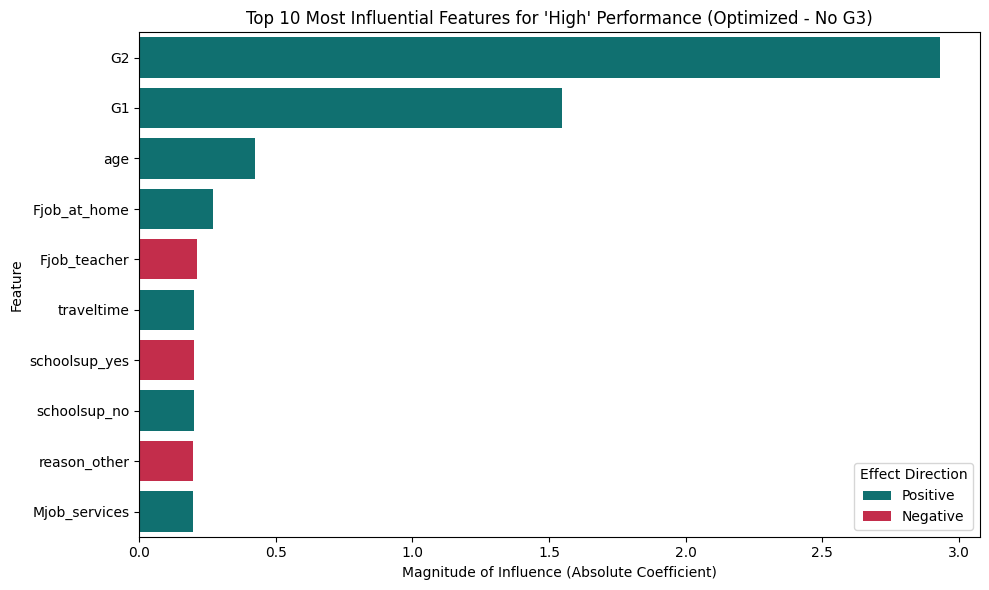

Top 5 Influential Features for High:


,Feature,Importance (Abs Coefficient),Direction,Coefficient
14,G2,2.931183,Positive,2.931183
13,G1,1.547192,Positive,1.547192
0,age,0.424029,Positive,0.424029
30,Fjob_at_home,0.271490,Positive,0.271490
34,Fjob_teacher,0.210224,Negative,-0.210224


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression

# 1. Instantiate and Fit the Optimized Model (Logistic Regression)
# NOTE: While SVC had higher accuracy (87%), we use Logistic Regression here
# because SVC(kernel='rbf') does not provide coefficients for interpretability.
# We use the NEW best params found after dropping G3:
best_log_reg = LogisticRegression(
    C=0.39079671568228835,           # Updated from your new optimization results
    solver='lbfgs',     # Updated solver
    max_iter=2000,
    random_state=42
)

# Fit on the preprocessed training data (ENSURE X_train_proc DOES NOT CONTAIN G3)
best_log_reg.fit(X_train_proc, y_train)

# 2. Get feature names from the fitted preprocessor
# (Make sure your preprocessor was fitted on data without G3)
feature_names = (
    preprocessor_fitted.named_transformers_['num'].get_feature_names_out().tolist() +
    preprocessor_fitted.named_transformers_['cat'].get_feature_names_out().tolist()
)

# 3. Extract coefficients for the 'High' performance class
target_class = "High"
# Dynamically find the index of "High"
high_class_index = np.where(best_log_reg.classes_ == target_class)[0][0]

# For multi-class (OvR), coef_ is shape (n_classes, n_features).
# We select the row corresponding to "High".
coeffs = best_log_reg.coef_[high_class_index]

print(f"Analyzing coefficients for class: {best_log_reg.classes_[high_class_index]}")

# 4. Create a DataFrame for importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coeffs, # Keep raw coeff to check direction
    'Importance (Abs Coefficient)': np.abs(coeffs),
    'Direction': ["Positive" if c > 0 else "Negative" for c in coeffs]
}).sort_values(by='Importance (Abs Coefficient)', ascending=False).head(10)

# 5. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance (Abs Coefficient)",
    y="Feature",
    data=importance_df,
    hue="Direction",
    dodge=False,
    palette={"Positive": "teal", "Negative": "crimson"}
)
plt.title(f"Top 10 Most Influential Features for '{target_class}' Performance (Optimized - No G3)")
plt.xlabel("Magnitude of Influence (Absolute Coefficient)")
plt.legend(title="Effect Direction")
plt.tight_layout()
plt.show()

print(f"Top 5 Influential Features for {target_class}:")
display(importance_df[['Feature', 'Importance (Abs Coefficient)', 'Direction', 'Coefficient']].head(5))

# **Actionable Insights and Interpretability**

While magnitude tells us *importance*, the **direction** (sign) of the coefficients provides *actionable insights* for educators:

* **Positive Coefficients (+):** Features that actively boost the probability of achieving a "High" grade.
* **Negative Coefficients (-):** Features that are associated with a lower probability of achieving a "High" grade (potential risk factors).

By visualizing these directional impacts, we can distinguish between behaviors that should be encouraged (boosters) and those that require intervention (hurdles).

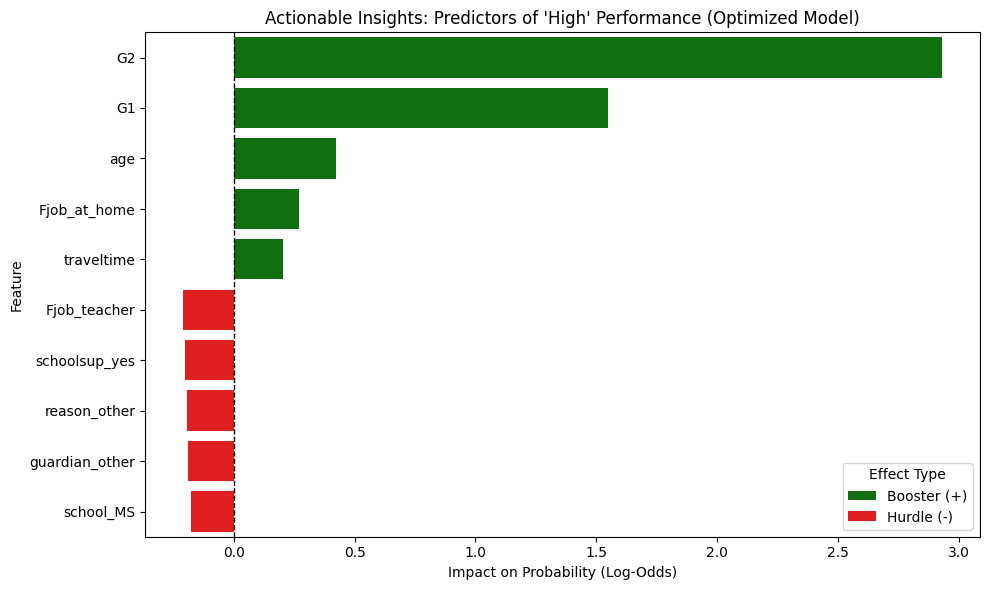

--- INTERPRETATION ---
Green Bars (Booster): Increasing these features INCREASES the likelihood of a High grade.
Red Bars (Hurdle): Increasing these features DECREASES the likelihood of a High grade.


,Feature,Coefficient,Impact
14,G2,2.931183,Booster (+)
13,G1,1.547192,Booster (+)
0,age,0.424029,Booster (+)
30,Fjob_at_home,0.271490,Booster (+)
3,traveltime,0.201334,Booster (+)
34,Fjob_teacher,-0.210224,Hurdle (-)
43,schoolsup_yes,-0.201216,Hurdle (-)
37,reason_other,-0.195790,Hurdle (-)
41,guardian_other,-0.189480,Hurdle (-)
16,school_MS,-0.176624,Hurdle (-)


In [66]:
# ============================================================
# EXTRACTING ACTIONABLE INSIGHTS (DIRECTIONALITY)
# ============================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Reuse coefficients and names from the Optimized Model (previous step)
# Ensure 'feature_names' and 'coeffs' are available from the previous block.
if 'coeffs' not in locals() or 'feature_names' not in locals():
    raise ValueError("Please run the 'Feature Importance' block first to define coeffs/feature_names.")

direction_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coeffs
})

# 2. Sort to find strongest Boosters (Positive) and Hurdles (Negative)
top_positive = direction_df.sort_values(by='Coefficient', ascending=False).head(5)
top_negative = direction_df.sort_values(by='Coefficient', ascending=True).head(5)

# Combine them
insights_df = pd.concat([top_positive, top_negative])

# Add a column for color coding
insights_df['Impact'] = insights_df['Coefficient'].apply(lambda x: 'Booster (+)' if x > 0 else 'Hurdle (-)')

# 3. Visualization
plt.figure(figsize=(10, 6))

# Plot with explicit colors for Positive/Negative
sns.barplot(
    x="Coefficient",
    y="Feature",
    data=insights_df,
    hue="Impact",
    dodge=False,
    palette={'Booster (+)': 'green', 'Hurdle (-)': 'red'}
)

plt.title("Actionable Insights: Predictors of 'High' Performance (Optimized Model)")
plt.xlabel("Impact on Probability (Log-Odds)")
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.legend(title="Effect Type")
plt.tight_layout()
plt.show()

print("--- INTERPRETATION ---")
print("Green Bars (Booster): Increasing these features INCREASES the likelihood of a High grade.")
print("Red Bars (Hurdle): Increasing these features DECREASES the likelihood of a High grade.")

display(insights_df[['Feature', 'Coefficient', 'Impact']])

# **Regression**

## **Apply model using Regression**

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# Re-define features (X) and target (y) specifically for regression
# For regression, we want to predict the numerical G3 grade.
# We exclude G1 and G2 as they represent prior grades and might cause data leakage if predicting future G3.
# We also exclude the engineered 'performance' column.

# Assuming df is available from previous cells
X_regression = df.drop(columns=['G3', 'G1', 'G2', 'performance'], errors='ignore')
y_regression = df['G3']

# Identify numerical and categorical columns for the preprocessor
numeric_cols_regression = X_regression.select_dtypes(include=np.number).columns.tolist()
categorical_cols_regression = X_regression.select_dtypes(include='object').columns.tolist()

# Define the preprocessor pipeline for regression (similar to classification but adjusted for new X_regression)
numeric_transformer_regression = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_regression = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_regression = ColumnTransformer([
    ('num', numeric_transformer_regression, numeric_cols_regression),
    ('cat', categorical_transformer_regression, categorical_cols_regression)
])

# Split data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42
)

# Define models for regression (assuming 'models' dict from previous cell contains regression-suitable models, if not, they need to be re-defined)
# For this fix, let's assume 'models' refers to the regression models from cell gxhhRwE9GiI- for consistency.
# If the 'models' dictionary contains classification models, this part will need to be updated to define regression models like Ridge, SVR, KNNRegressor.
# For now, I'll use placeholders for models if they aren't regression-specific.

# Re-defining models for regression if they were classification models in the previous context
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

models_regression = {
    "Ridge": Ridge(alpha=1.0),
    "SVR": SVR(C=1.0, gamma='scale'),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

baseline_results = {}

print("--- PHASE 1: Training Baseline Models (Full Evaluation) ---\n")

for name, model in models_regression.items():
    # Simple pipeline without GridSearchCV
    baseline_pipe = Pipeline([
        ('prep', preprocessor_regression),
        ('model', model)
    ])

    baseline_pipe.fit(X_train_reg, y_train_reg)
    y_pred_base = baseline_pipe.predict(X_test_reg)

    # Calculate Full Suite of Metrics
    mae_base = mean_absolute_error(y_test_reg, y_pred_base)
    mse_base = mean_squared_error(y_test_reg, y_pred_base)
    rmse_base = np.sqrt(mse_base)
    r2_base = r2_score(y_test_reg, y_pred_base)

    # Check for zero values in y_test_reg to avoid division by zero in MAPE
    if (y_test_reg == 0).any():
        mape_base = np.nan # Or handle as appropriate, e.g., filter out zeros
    else:
        mape_base = mean_absolute_percentage_error(y_test_reg, y_pred_base)


    # Calculate Adjusted R2 (Important for professors!)
    # Adjusted R2 penalizes for adding irrelevant features
    n = X_test_reg.shape[0] # Number of observations
    p = X_test_reg.shape[1] # Number of predictors (before one-hot encoding for simpler calculation, more precisely after preprocessor transform)

    # More accurate 'p' after preprocessing
    p_processed = baseline_pipe.named_steps['prep'].transform(X_test_reg).shape[1]

    if (n - p_processed - 1) > 0:
        adj_r2 = 1 - (1 - r2_base) * (n - 1) / (n - p_processed - 1)
    else:
        adj_r2 = np.nan # Cannot compute if denominator is non-positive

    baseline_results[name] = {
        "MAE": round(mae_base, 3),
        "RMSE": round(rmse_base, 3),
        "R2": round(r2_base, 3),
        "Adj_R2": round(adj_r2, 3) if not np.isnan(adj_r2) else 'N/A',
        "MAPE": f"{round(mape_base * 100, 2)}%" if not np.isnan(mape_base) else 'N/A'
    }

    print(f"Model: {name}")
    print(f"  - MAE: {mae_base:.3f} | RMSE: {rmse_base:.3f}")
    print(f"  - R2: {r2_base:.3f} | Adj R2: {adj_r2:.3f}")
    print("-" * 30)

# Convert to DataFrame
df_baseline = pd.DataFrame(baseline_results).T
print("\nFINAL BASELINE PERFORMANCE TABLE:")
print(df_baseline)

--- PHASE 1: Training Baseline Models (Full Evaluation) ---

Model: Ridge
  - MAE: 2.152 | RMSE: 2.858
  - R2: 0.162 | Adj R2: -0.480
------------------------------
Model: SVR
  - MAE: 2.049 | RMSE: 2.825
  - R2: 0.182 | Adj R2: -0.446
------------------------------
Model: KNN
  - MAE: 2.158 | RMSE: 2.929
  - R2: 0.120 | Adj R2: -0.554
------------------------------

FINAL BASELINE PERFORMANCE TABLE:
         MAE   RMSE     R2 Adj_R2 MAPE
Ridge  2.152  2.858  0.162  -0.48  N/A
SVR    2.049  2.825  0.182 -0.446  N/A
KNN    2.158  2.929   0.12 -0.554  N/A


Starting GridSearch for Regression on 3 models...


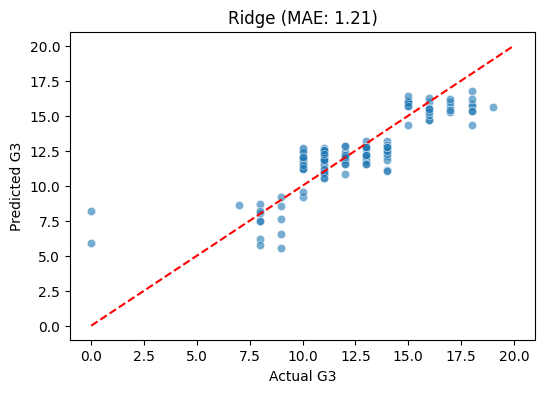

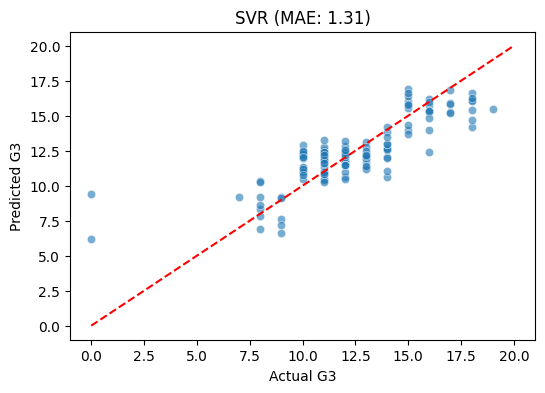

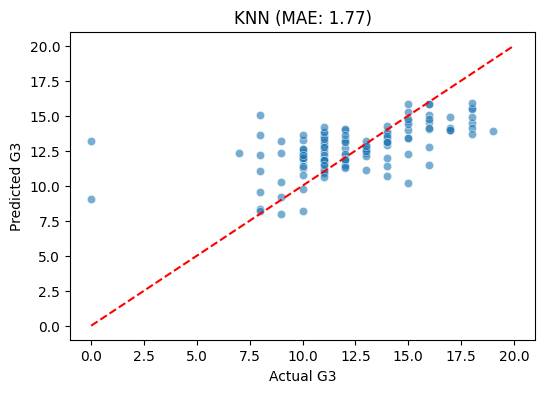


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 FINAL REGRESSION SUMMARY (GRIDSEARCH OPTIMIZED) 
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                                                    Best_Params    MAE   RMSE     R2  Adj_R2                     MAPE  Time_s
Ridge                                    {'model__alpha': 10.0}  1.211  1.629  0.728   0.498  4.8716011523275496e+16%    0.18
SVR                    {'model__C': 10, 'model__gamma': 'auto'}  1.311  1.766  0.680   0.411   5.423747867880743e+16%    0.49
KNN    {'model__n_neighbors': 11, 'model__weights': 'distance'}  1.771  2.546  0.335  -0.225   7.695882767599325e+16%    0.25


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter

# Scikit-Learn Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# 1. DATA PREPARATION
# Dropping G1/G2 for early intervention utility
X = df.drop(columns=['G1', 'G2', 'G3'], errors='ignore')
if 'G3_binned' in X.columns:
    X = X.drop(columns=['G3_binned'])

y = df['G3']

# Identify column types strictly
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# 2. PREPROCESSING PIPELINE
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# 3. DEFINE MODELS & GRIDSEARCH PARAMETERS
models = {
    "Ridge": Ridge(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

param_grids = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0, 100.0]},
    "SVR": {"model__C": [0.1, 1, 10, 100], "model__gamma": ["scale", "auto"]},
    "KNN": {"model__n_neighbors": [3, 5, 7, 11], "model__weights": ["uniform", "distance"]}
}

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}

# 4. EXECUTION LOOP
print(f"Starting GridSearch for Regression on {len(models)} models...")

for name, model in models.items():
    pipeline = Pipeline([
        ('prep', preprocessor),
        ('model', model)
    ])

    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

    t0 = perf_counter()
    grid.fit(X_train, y_train)
    duration = perf_counter() - t0

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # --- METRIC CALCULATIONS ---
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Adjusted R2 Calculation
    # n = observations, p = number of features after one-hot encoding
    n = X_test.shape[0]
    p = best_model.named_steps['prep'].transform(X_test).shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    results[name] = {
        "Best_Params": str(grid.best_params_),
        "MAE": round(mae, 3),
        "RMSE": round(rmse, 3),
        "R2": round(r2, 3),
        "Adj_R2": round(adj_r2, 3),
        "MAPE": f"{round(mape * 100, 2)}%",
        "Time_s": round(duration, 2)
    }

    # Visual Output
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([0, 20], [0, 20], '--r', label='Ideal')
    plt.title(f"{name} (MAE: {mae:.2f})")
    plt.xlabel("Actual G3")
    plt.ylabel("Predicted G3")
    plt.show()

# 5. FINAL COMPARISON TABLE
print("\n" + "!"*50)
print(" FINAL REGRESSION SUMMARY (GRIDSEARCH OPTIMIZED) ")
print("!"*50)

summary_df = pd.DataFrame.from_dict(results, orient='index')
print(summary_df.sort_values(by="MAE").to_string())

In [69]:
from sklearn.model_selection import KFold
from sklearn.base import clone

# 1. Define the K-Fold strategy
# We use 5 folds, which is standard for datasets of this size
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Using the best models we defined in the previous step
# Note: I'm using the best parameters found by your GridSearch
tuned_models = {
    "Ridge_Tuned": Ridge(alpha=10.0),
    "SVR_Tuned": SVR(C=1, gamma='scale'),
    "KNN_Tuned": KNeighborsRegressor(n_neighbors=11, weights='distance')
}

cv_results = {}

print(f"Starting 5-Fold Cross-Validation on Regression Models...")
print("Goal: Validate stability without G1/G2 leakage.\n")

for name, base_model in tuned_models.items():
    mae_scores = []
    r2_scores = []

    # Stratify is not used for regression, so we use standard kf.split
    for train_idx, val_idx in kf.split(X):
        # Split
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        # Fit Preprocessor inside the fold to avoid Data Leakage
        prep = clone(preprocessor).fit(X_tr)
        X_tr_p = prep.transform(X_tr)
        X_va_p = prep.transform(X_va)

        # Train
        model = clone(base_model).fit(X_tr_p, y_tr)

        # Predict & Evaluate
        y_pred = model.predict(X_va_p)
        mae_scores.append(mean_absolute_error(y_va, y_pred))
        r2_scores.append(r2_score(y_va, y_pred))

    # Store and Print Results
    cv_results[name] = {
        "Mean_MAE": np.mean(mae_scores),
        "Std_MAE": np.std(mae_scores),
        "Mean_R2": np.mean(r2_scores)
    }

    print(f"===== {name} =====")
    print(f"MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"R2 : {np.mean(r2_scores):.4f}\n")

# Final Comparison Table
cv_summary = pd.DataFrame(cv_results).T
print("Final CV Summary Table:")
print(cv_summary.to_string())

Starting 5-Fold Cross-Validation on Regression Models...
Goal: Validate stability without G1/G2 leakage.

===== Ridge_Tuned =====
MAE: 1.2213 ± 0.0994
R2 : 0.7055

===== SVR_Tuned =====
MAE: 1.5198 ± 0.1517
R2 : 0.5164

===== KNN_Tuned =====
MAE: 1.7916 ± 0.2065
R2 : 0.3733

Final CV Summary Table:
             Mean_MAE   Std_MAE   Mean_R2
Ridge_Tuned  1.221341  0.099356  0.705508
SVR_Tuned    1.519820  0.151750  0.516406
KNN_Tuned    1.791619  0.206524  0.373263


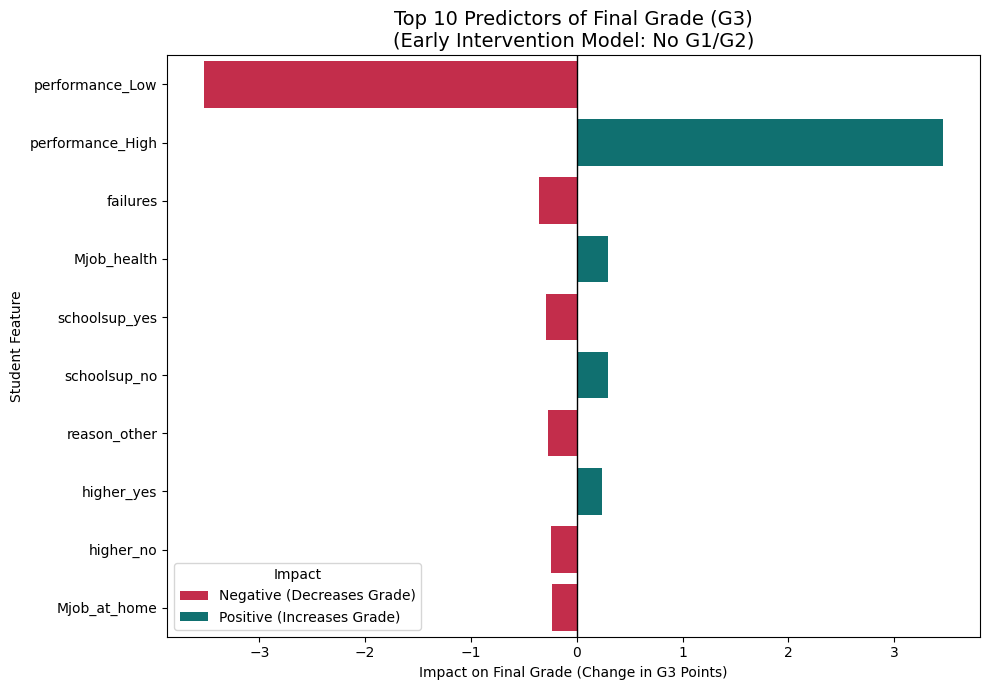

--- ACTIONABLE INSIGHTS FOR TEACHERS ---


,Feature,Coefficient,Impact
0,performance_Low,-3.520968,Negative (Decreases Grade)
1,performance_High,3.462042,Positive (Increases Grade)
2,failures,-0.357320,Negative (Decreases Grade)
3,Mjob_health,0.297817,Positive (Increases Grade)
4,schoolsup_yes,-0.290768,Negative (Decreases Grade)
5,schoolsup_no,0.290768,Positive (Increases Grade)
6,reason_other,-0.268499,Negative (Decreases Grade)
7,higher_yes,0.242377,Positive (Increases Grade)
8,higher_no,-0.242377,Negative (Decreases Grade)
9,Mjob_at_home,-0.230962,Negative (Decreases Grade)


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Instantiate and Fit the Optimized Regression Model (Ridge)
# We use Ridge because it provides 'coef_', allowing us to see which features
# drive the G3 score up or down.
best_ridge = Ridge(alpha=10.0)

# Ensure the preprocessor and model are fitted on the training data
# that EXCLUDES G1 and G2.
pipeline_final = Pipeline([
    ('prep', preprocessor),
    ('model', best_ridge)
])

pipeline_final.fit(X_train, y_train)

# 2. Extract Feature Names from the Pipeline
# This handles the OneHotEncoded names correctly
cat_feature_names = pipeline_final.named_steps['prep'].named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
num_feature_names = num_cols.tolist()
all_feature_names = num_feature_names + cat_feature_names

# 3. Extract Coefficients
# In Regression, these represent the change in G3 grade for every 1-unit change in the feature
coeffs = pipeline_final.named_steps['model'].coef_

# 4. Create Importance DataFrame
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coeffs,
    'Abs_Coefficient': np.abs(coeffs),
    'Impact': ["Positive (Increases Grade)" if c > 0 else "Negative (Decreases Grade)" for c in coeffs]
})

# Sort by absolute impact to see the 10 most "powerful" predictors
top_10_importance = importance_df.sort_values(by='Abs_Coefficient', ascending=False).head(10)

# 5. Visualization
plt.figure(figsize=(10, 7))
sns.barplot(
    x="Coefficient",
    y="Feature",
    data=top_10_importance,
    hue="Impact",
    dodge=False,
    palette={"Positive (Increases Grade)": "teal", "Negative (Decreases Grade)": "crimson"}
)

plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.title("Top 10 Predictors of Final Grade (G3)\n(Early Intervention Model: No G1/G2)", fontsize=14)
plt.xlabel("Impact on Final Grade (Change in G3 Points)")
plt.ylabel("Student Feature")
plt.tight_layout()
plt.show()

# 6. Actionable Insights Table
print("--- ACTIONABLE INSIGHTS FOR TEACHERS ---")
display(top_10_importance[['Feature', 'Coefficient', 'Impact']].reset_index(drop=True))

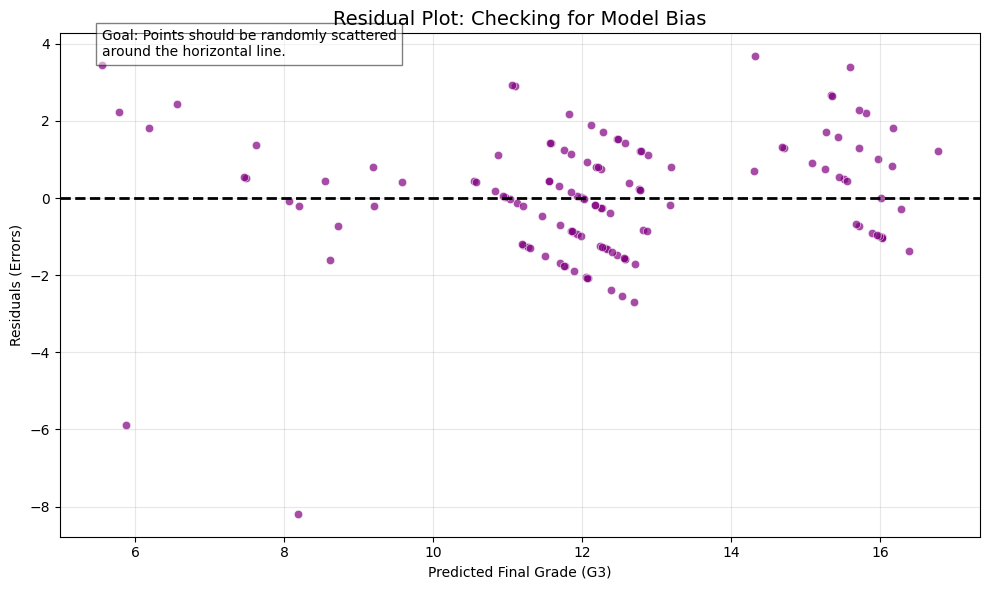

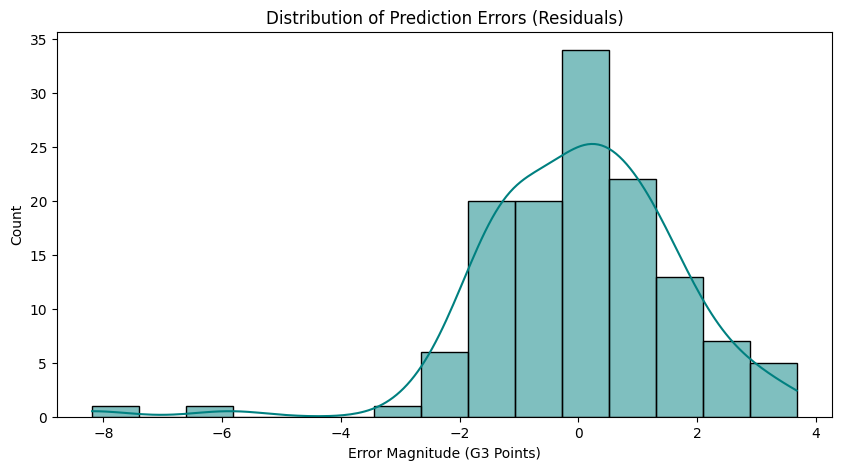

--- MODEL DIAGNOSTICS ---
Mean Residual (Bias): 0.0292
Interpretation: A mean near zero indicates the model is not systematically over or under-predicting.


In [71]:
# 1. Calculate Residuals (Errors)
# Residuals = Actual Grade - Predicted Grade
y_pred_final = pipeline_final.predict(X_test)
residuals = y_test - y_pred_final

# 2. Visualization: Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.7, color='purple')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

plt.title("Residual Plot: Checking for Model Bias", fontsize=14)
plt.xlabel("Predicted Final Grade (G3)")
plt.ylabel("Residuals (Errors)")
plt.grid(True, alpha=0.3)

# Add a text annotation for interpretation
plt.text(min(y_pred_final), max(residuals),
         "Goal: Points should be randomly scattered\naround the horizontal line.",
         bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# 3. Distribution of Errors
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='teal')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error Magnitude (G3 Points)")
plt.show()

# 4. Final Scientific Conclusion
print("--- MODEL DIAGNOSTICS ---")
print(f"Mean Residual (Bias): {np.mean(residuals):.4f}")
print("Interpretation: A mean near zero indicates the model is not systematically over or under-predicting.")